In [127]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [289]:
df = pdr.get_data_fred('ICNSA')

In [290]:
df.head()

,ICNSA
DATE,
2019-02-09,242762
2019-02-16,210679
2019-02-23,203049
2019-03-02,220540
2019-03-09,209302


<Axes: xlabel='DATE'>

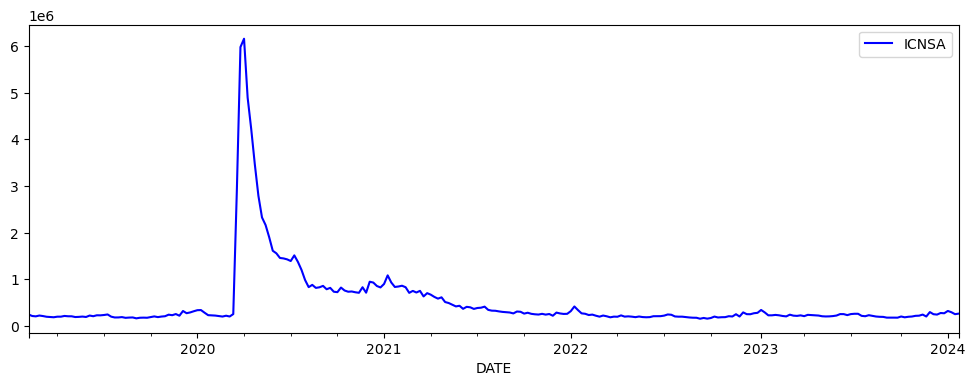

In [291]:
# plotting the dataset
df.plot(figsize=(12,4),c='blue')

<Axes: xlabel='DATE'>

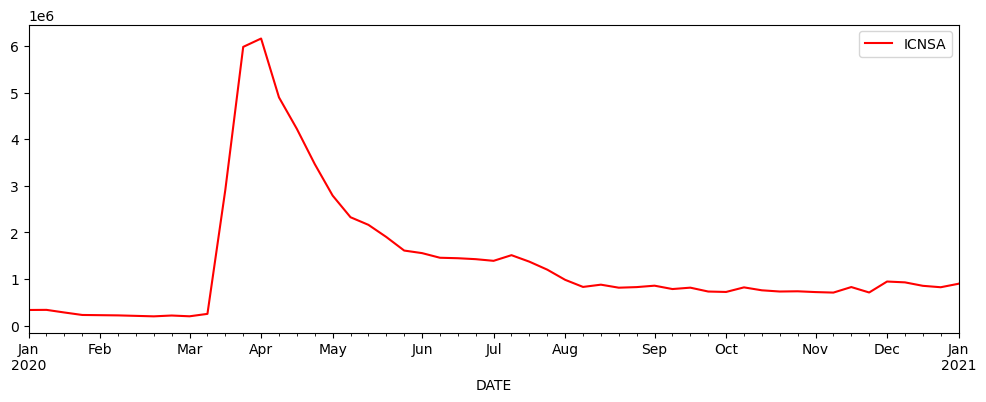

In [292]:
# we can see a spike during the covid times suggesting high insurance claims
df.plot(xlim=['2020-01-01','2021-01-01'],figsize=(12,4),c='red')

In [293]:
# Handling extreme values during COVID years using winsorization
from scipy.stats.mstats import winsorize
df['ICNSA'] = winsorize(df['ICNSA'],(0.4,0.4))

<Axes: xlabel='DATE'>

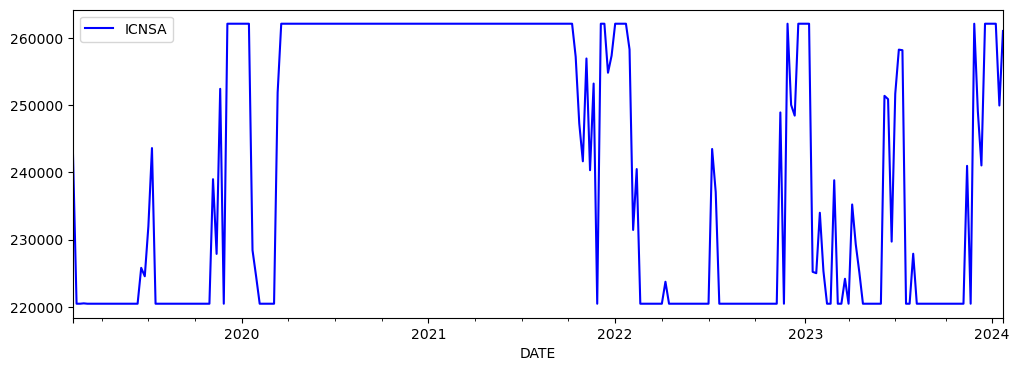

In [294]:
df.plot(figsize=(12,4),c='blue')

<Axes: xlabel='DATE'>

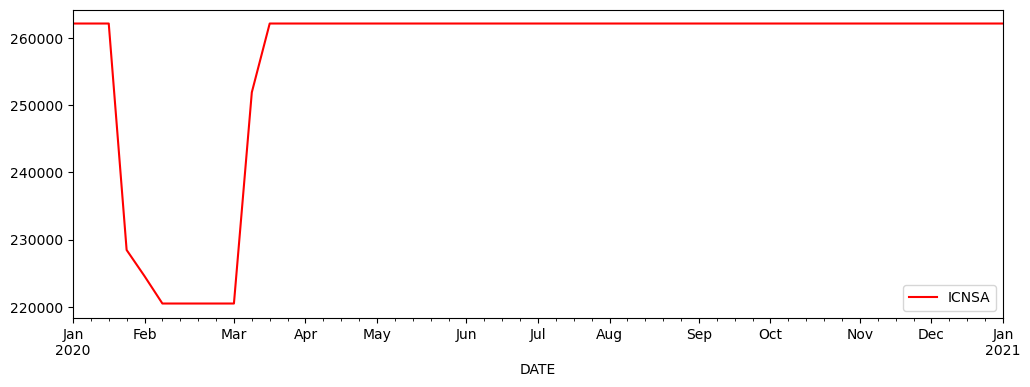

In [295]:
df.plot(xlim=['2020-01-01','2021-01-01'],figsize=(12,4),c='red')

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2019-02-09 to 2024-01-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ICNSA   260 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [297]:
df.index

DatetimeIndex(['2019-02-09', '2019-02-16', '2019-02-23', '2019-03-02',
               '2019-03-09', '2019-03-16', '2019-03-23', '2019-03-30',
               '2019-04-06', '2019-04-13',
               ...
               '2023-11-25', '2023-12-02', '2023-12-09', '2023-12-16',
               '2023-12-23', '2023-12-30', '2024-01-06', '2024-01-13',
               '2024-01-20', '2024-01-27'],
              dtype='datetime64[ns]', name='DATE', length=260, freq=None)

In [298]:
df.reset_index(level=0, inplace=True,names='ds')
df.rename(columns = {'ICNSA':'y'}, inplace = True)
df.head()

,ds,y
0,2019-02-09,242762
1,2019-02-16,220486
2,2019-02-23,220486
3,2019-03-02,220540
4,2019-03-09,220486


In [299]:
len(df)

260

In [300]:
train_data = df.iloc[:211]
test_data = df.iloc[211:]
print(len(train_data))
print(len(test_data))

211
49


In [301]:
test_data.head()

,ds,y
211,2023-02-25,220486
212,2023-03-04,238840
213,2023-03-11,220486
214,2023-03-18,220486
215,2023-03-25,224193


In [302]:
model = Prophet()

In [303]:
model.fit(train_data)

01:21:33 - cmdstanpy - INFO - Chain [1] start processing
01:21:33 - cmdstanpy - INFO - Chain [1] done processing


In [304]:
### Create future dates of 365 days
future_dates=model.make_future_dataframe(periods=49,freq='W-SAT')
future_dates.tail()

,ds
255,2023-12-30
256,2024-01-06
257,2024-01-13
258,2024-01-20
259,2024-01-27


In [305]:
prediction = model.predict(future_dates)

In [306]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-09,219257.385125,202252.682948,226176.435319,219257.385125,219257.385125,-4610.788044,-4610.788044,-4610.788044,-4610.788044,-4610.788044,-4610.788044,0.0,0.0,0.0,214646.597081
1,2019-02-16,219632.418688,200265.347740,224320.628382,219632.418688,219632.418688,-7134.544517,-7134.544517,-7134.544517,-7134.544517,-7134.544517,-7134.544517,0.0,0.0,0.0,212497.874171
2,2019-02-23,220007.452252,197918.898762,222535.920966,220007.452252,220007.452252,-9711.068726,-9711.068726,-9711.068726,-9711.068726,-9711.068726,-9711.068726,0.0,0.0,0.0,210296.383525
3,2019-03-02,220382.485815,197817.525624,220804.800486,220382.485815,220382.485815,-10853.422487,-10853.422487,-10853.422487,-10853.422487,-10853.422487,-10853.422487,0.0,0.0,0.0,209529.063328
4,2019-03-09,220757.519378,199831.393205,224495.325236,220757.519378,220757.519378,-8921.563688,-8921.563688,-8921.563688,-8921.563688,-8921.563688,-8921.563688,0.0,0.0,0.0,211835.955690


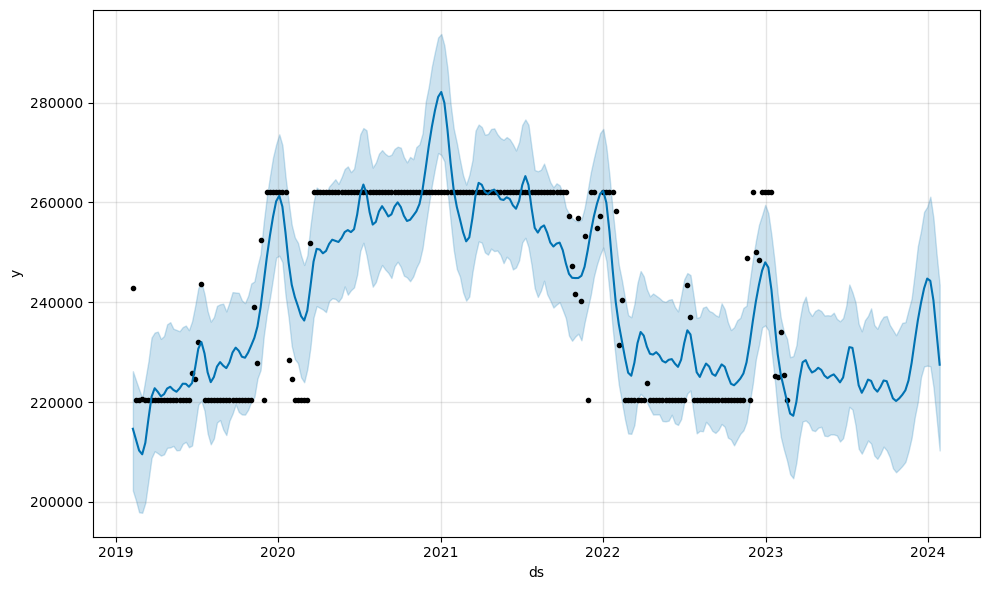

In [307]:
model.plot(prediction);

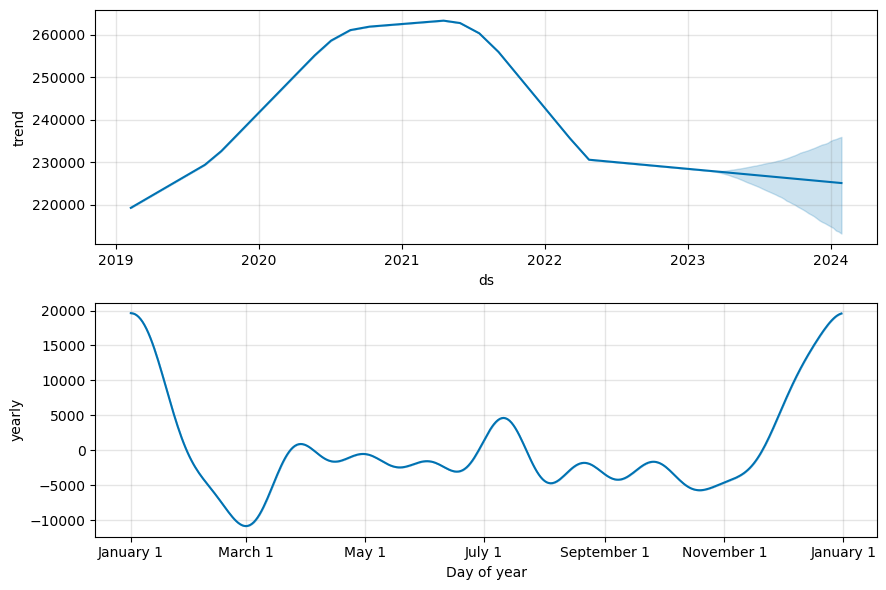

In [308]:
#### Visualize Each Components[Trends,yearly]
model.plot_components(prediction);

<Axes: xlabel='ds'>

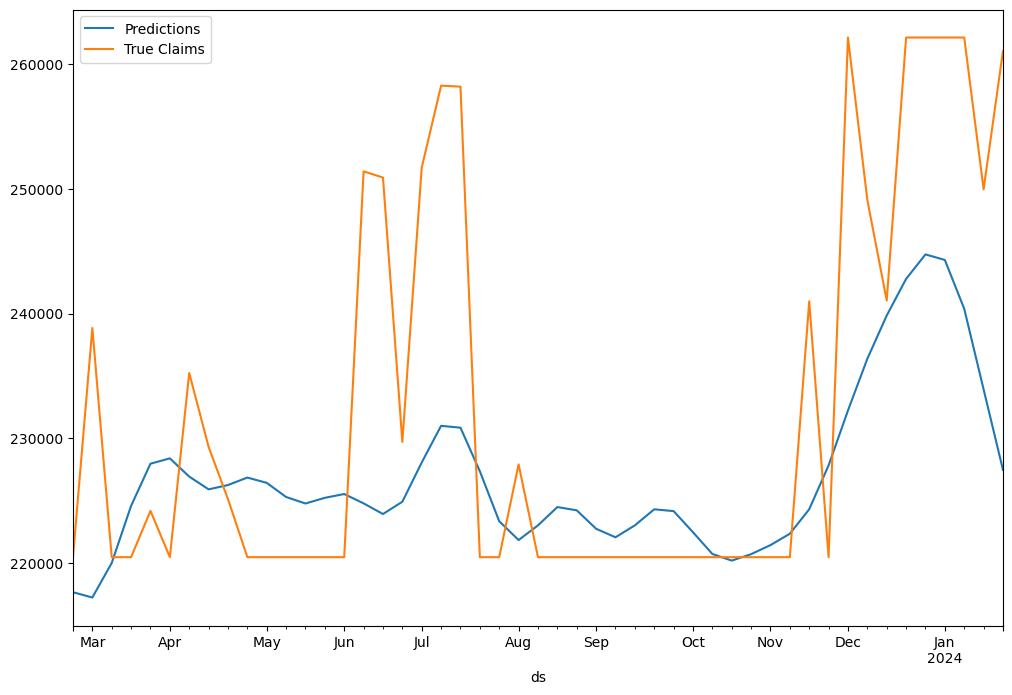

In [309]:
ax = prediction[211:].plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

test_data.plot(x='ds',y='y',label='True Claims',legend=True,ax=ax)

In [310]:
from statsmodels.tools.eval_measures import rmse
prediction_values = prediction.iloc[-49:]['yhat']
rmse(prediction_values,test_data['y'])

13349.323775390385

In [311]:
'''
Prophet Diagnostics
Prophet includes functionality for time series cross validation to measure forecast error using historical data. 
This is done by selecting cutoff points in the history, 
and for each of them fitting the model using data only up to that cutoff point. 
We can then compare the forecasted values to the actual values.
'''
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

01:21:41 - cmdstanpy - INFO - Chain [1] start processing
01:21:42 - cmdstanpy - INFO - Chain [1] done processing
01:21:42 - cmdstanpy - INFO - Chain [1] start processing
01:21:42 - cmdstanpy - INFO - Chain [1] done processing
01:21:42 - cmdstanpy - INFO - Chain [1] start processing
01:21:42 - cmdstanpy - INFO - Chain [1] done processing


In [312]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-02-27,252503.072375,241809.956644,262752.903660,262105,2021-02-23
1,2021-03-06,254234.275549,242854.792655,264989.509136,262105,2021-02-23
2,2021-03-13,260886.723805,251903.705650,271946.160699,262105,2021-02-23
3,2021-03-20,268822.737948,258197.832810,280015.878191,262105,2021-02-23
4,2021-03-27,273211.749601,262327.248253,284660.471402,262105,2021-02-23


In [313]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,34 days,3.023771e+08,17388.993882,13725.215195,0.059142,0.030029,0.056614,0.6
1,36 days,3.571225e+08,18897.683795,14599.985349,0.063110,0.030029,0.060073,0.6
2,39 days,3.583621e+08,18930.454494,14661.574834,0.063345,0.030029,0.060210,0.6
3,41 days,3.601315e+08,18977.129698,14821.077024,0.063953,0.030029,0.060832,0.6
4,43 days,4.163479e+08,20404.605528,15703.209204,0.067954,0.030029,0.064312,0.6
